In [1]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [2]:
import Augmentor

In [61]:
Normal_train = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set/normal")

Insufficient rights to read or write output directory (/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set/normal/output)
Initialised with 175 image(s) found.
Output directory set to /kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set/normal/output.

In [63]:
Glaucoma_train = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set/glaucoma")

Insufficient rights to read or write output directory (/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set/glaucoma/output)
Initialised with 106 image(s) found.
Output directory set to /kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set/glaucoma/output.

In [64]:
Glaucoma_test = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set/glaucoma")

Insufficient rights to read or write output directory (/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set/glaucoma/output)
Initialised with 56 image(s) found.
Output directory set to /kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set/glaucoma/output.

In [65]:
Normal_test = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set/normal")

Insufficient rights to read or write output directory (/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set/normal/output)
Initialised with 108 image(s) found.
Output directory set to /kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set/normal/output.

In [3]:
p = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set",output_directory="/kaggle/working/output")

Initialised with 281 image(s) found.
Output directory set to /kaggle/working/output.

In [4]:
p1 = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set",output_directory="/kaggle/working/output1")
#normal=108
#glaucoma=56

Initialised with 164 image(s) found.
Output directory set to /kaggle/working/output1.

In [5]:
#Step 3 Define the Operations
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(200)

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=488x488 at 0x78E038987F70>: 100%|██████████| 200/200 [00:15<00:00, 12.62 Samples/s]


In [6]:
#Step 3 Define the Operations
p1.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p1.sample(200)

Processing <PIL.Image.Image image mode=RGB size=380x380 at 0x78E03894E080>: 100%|██████████| 200/200 [00:09<00:00, 20.38 Samples/s]                


In [7]:
import pathlib
import tensorflow as tf

data_dir_Training= pathlib.Path('/kaggle/working/output')
data_dir_Testing= pathlib.Path('/kaggle/working/output1')

img_height=224
img_width=224

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir_Training,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 200 files belonging to 2 classes.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_Testing,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 200 files belonging to 2 classes.


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_ds1 = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
image_batch1, labels_batch1 = next(iter(normalized_ds1))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
train_ds=normalized_ds
val_ds=normalized_ds1

0.18485646 0.9488226


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D,Conv2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model = ResNet50(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable = False
x = base_model.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [66]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model1 = VGG16(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model1.layers[:10]:
    layer.trainable = False
x = base_model1.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model1.inputs, outputs=predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D,Conv2D,Dense,Dropout
base_model2 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model2.layers[:10]:
    layer.trainable = False
x = base_model2.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model2.inputs, outputs=predictions)

87910968/87910968 [==============================] - 1s 0us/step


In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath1 = "/kaggle/working/My Drive/ResNet50_Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint1 = ModelCheckpoint(
    filepath=model_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath2 = "/kaggle/working/My Drive/VGG16_Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint2 = ModelCheckpoint(
    filepath=model_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath3 = "/kaggle/working/My Drive/InceptionV3_Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint3 = ModelCheckpoint(
    filepath=model_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [73]:
#model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001  # Set your desired learning rate
optimizer = Adam(learning_rate=learning_rate)

model1.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [74]:
#model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001  # Set your desired learning rate
optimizer = Adam(learning_rate=learning_rate)

model2.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [75]:
#model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001  # Set your desired learning rate
optimizer = Adam(learning_rate=learning_rate)

model3.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [76]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,callbacks=[checkpoint1])

Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8450
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /kaggle/working/My Drive/ResNet50_Final-01-0.6250.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 37s 566ms/step - loss: 0.3524 - accuracy: 0.8450 - val_loss: 14.0766 - val_accuracy: 0.6250
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.8800
Epoch 2: val_accuracy did not improve from 0.62500
7/7 [==============================] - 1s 206ms/step - loss: 0.2612 - accuracy: 0.8800 - val_loss: 8.8866 - val_accuracy: 0.6250
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9300
Epoch 3: val_accuracy did not improve from 0.62500
7/7 [==============================] - 1s 206ms/step - loss: 0.2082 - accuracy: 0.9300 - val_loss: 4.3416 - val_accuracy: 0.6250
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9600
Epoch 4: val_accuracy did not improve from 0.62500
7/7 [==============================] - 1s 207ms/step - loss: 0.1275 - accuracy: 0.9600 - val_loss: 4.0818 - val_accuracy: 0.6250
Epoch 5/10
7/7 [==============================] - ETA

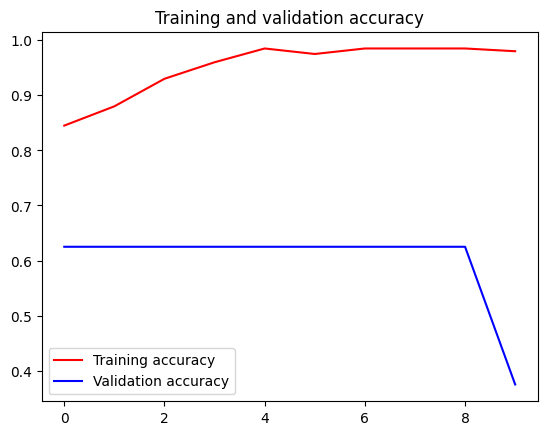

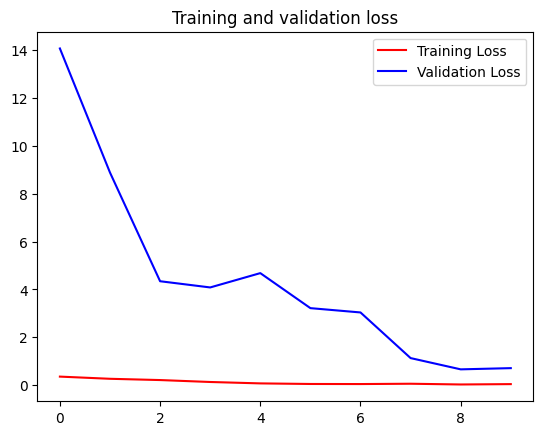

In [77]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [78]:
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,callbacks=[checkpoint2])

Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.5700
Epoch 1: val_accuracy did not improve from 0.64500
7/7 [==============================] - 9s 352ms/step - loss: 0.6738 - accuracy: 0.5700 - val_loss: 0.6605 - val_accuracy: 0.6250
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.6100
Epoch 2: val_accuracy did not improve from 0.64500
7/7 [==============================] - 1s 159ms/step - loss: 0.6720 - accuracy: 0.6100 - val_loss: 0.6590 - val_accuracy: 0.6250
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.6150
Epoch 3: val_accuracy did not improve from 0.64500
7/7 [==============================] - 1s 160ms/step - loss: 0.6441 - accuracy: 0.6150 - val_loss: 0.6489 - val_accuracy: 0.6250
Epoch 4/10
6/7 [========================>.....] - ETA: 0s - loss: 0.6192 - accuracy: 0.6406
Epoch 4: val_accuracy improved from 0.64500 to 0.71000, saving model to /kaggle/working/My D

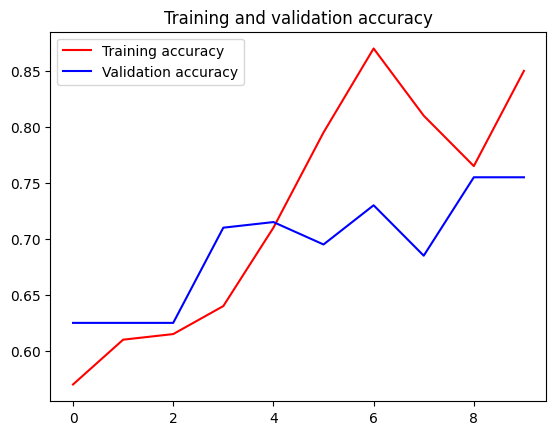

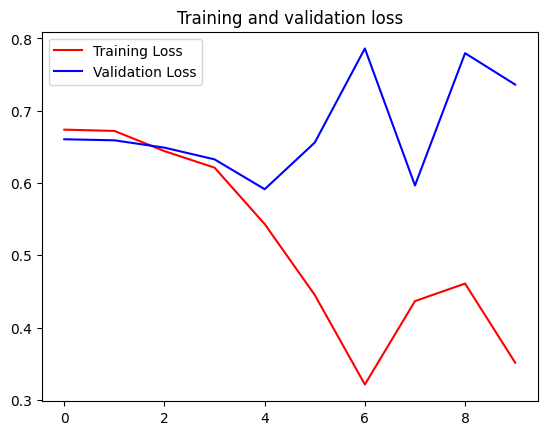

In [79]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [80]:
history3=model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,callbacks=[checkpoint3])

Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /kaggle/working/My Drive/InceptionV3_Final-01-0.6250.hdf5
7/7 [==============================] - 35s 582ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 23.3995 - val_accuracy: 0.6250
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9900
Epoch 2: val_accuracy did not improve from 0.62500
7/7 [==============================] - 1s 165ms/step - loss: 0.0438 - accuracy: 0.9900 - val_loss: 14.5622 - val_accuracy: 0.6250
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.62500
7/7 [==============================] - 1s 165ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 10.5081 - val_accuracy: 0.6250
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 4: val

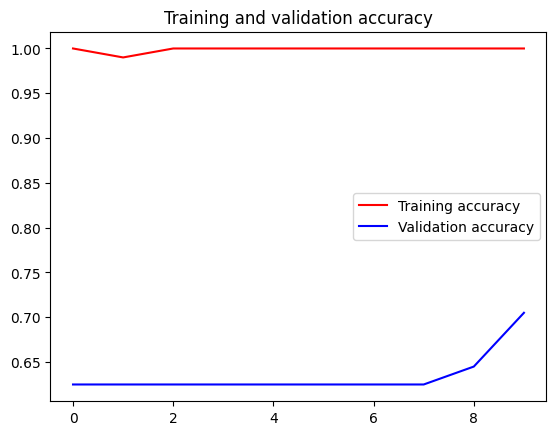

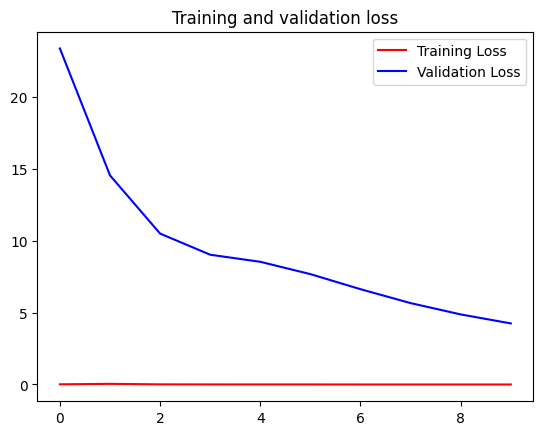

In [81]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [83]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
import numpy as np
model_1 = load_model('/kaggle/working/My Drive/ResNet50_Final-01-0.6250.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='ResNet50')
#model_2 = load_model('/kaggle/working/My Drive/DenseNet201-04-0.6625.hdf5')
#model_2 = Model(inputs=model_2.inputs,
             #outputs=model_2.outputs,
              #name='DenseNet202')
model_3 = load_model('/kaggle/working/My Drive/InceptionV3_Final-09-0.6450.hdf5')
model_3 = Model(inputs=model_3.inputs,
             outputs=model_3.outputs,
              name='InceptionV3')
models = [model_1,model_3]



#w = np.array([0.7, 0.9])
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]

#ensemble = VotingClassifier(estimators=models, weights=w, voting='soft')
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [84]:


from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001  # Set your desired learning rate
optimizer = Adam(learning_rate=learning_rate)

ensemble_model.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [85]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25)

Epoch 1/25
7/7 [==============================] - 72s 755ms/step - loss: 0.1166 - accuracy: 1.0000 - val_loss: 1.7073 - val_accuracy: 0.6250
Epoch 2/25
7/7 [==============================] - 2s 359ms/step - loss: 0.0798 - accuracy: 1.0000 - val_loss: 0.7736 - val_accuracy: 0.6900
Epoch 3/25
7/7 [==============================] - 2s 360ms/step - loss: 0.0592 - accuracy: 1.0000 - val_loss: 0.6563 - val_accuracy: 0.7200
Epoch 4/25
7/7 [==============================] - 2s 359ms/step - loss: 0.0385 - accuracy: 0.9950 - val_loss: 0.7957 - val_accuracy: 0.7100
Epoch 5/25
7/7 [==============================] - 2s 359ms/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.5568 - val_accuracy: 0.7300
Epoch 6/25
7/7 [==============================] - 2s 360ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.5585 - val_accuracy: 0.7500
Epoch 7/25
7/7 [==============================] - 2s 361ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.7359 - val_accuracy: 0.7250
Epoch 8/25
7/7 [===

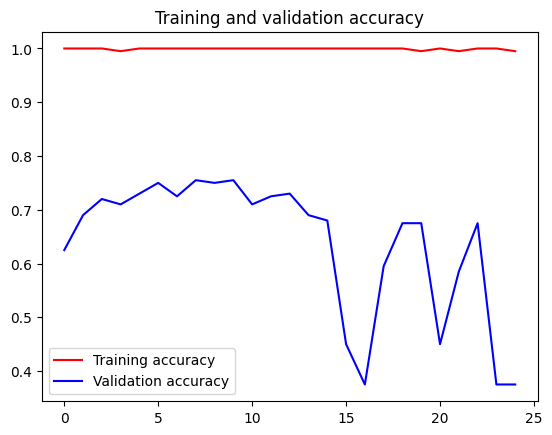

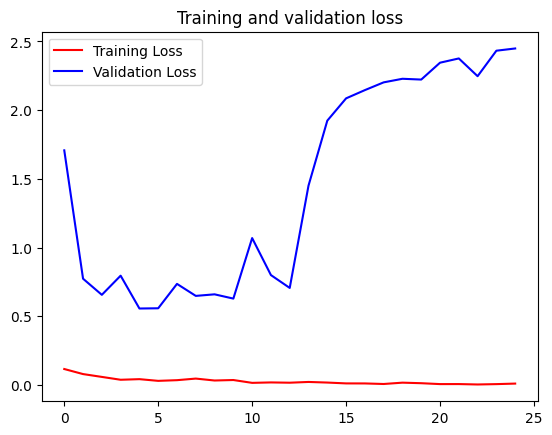

In [86]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [87]:

train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(200,)
(200,)


In [88]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 2132)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['normal','glaucoma']
print(classification_report(test_label, y_pred, target_names=target_names))




/tmp/ipykernel_47/2841421654.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 2132)


Confusion Matrix
[[ 75   0]
 [125   0]]
Classification Report
              precision    recall  f1-score   support

      normal       0.38      1.00      0.55        75
    glaucoma       0.00      0.00      0.00       125

    accuracy                           0.38       200
   macro avg       0.19      0.50      0.27       200
weighted avg       0.14      0.38      0.20       200



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
from tensorflow.keras.callbacks import EarlyStopping
# Assuming you've defined your model and datasets (train_ds, val_ds)

# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history3 = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
7/7 [==============================] - 3s 454ms/step - loss: 0.0137 - accuracy: 0.9950 - val_loss: 1.7596 - val_accuracy: 0.7000
Epoch 2/50
7/7 [==============================] - 3s 413ms/step - loss: 0.0099 - accuracy: 0.9950 - val_loss: 0.9466 - val_accuracy: 0.7150
Epoch 3/50
7/7 [==============================] - 3s 407ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.8517 - val_accuracy: 0.7100
Epoch 4/50
7/7 [==============================] - 3s 406ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.7377 - val_accuracy: 0.7200
Epoch 5/50
7/7 [==============================] - 3s 405ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.7300
Epoch 6/50
7/7 [==============================] - 3s 407ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5801 - val_accuracy: 0.7250
Epoch 7/50
7/7 [==============================] - 3s 409ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.5783 - val_accuracy: 0.7250
Epoch 8/50
7/7 [====

In [90]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(200,)
(200,)


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 2132)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['normal','glaucoma']
print(classification_report(test_label, y_pred, target_names=target_names))



/tmp/ipykernel_47/2968483857.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 2132)


Confusion Matrix
[[53 22]
 [33 92]]
Classification Report
              precision    recall  f1-score   support

      normal       0.62      0.71      0.66        75
    glaucoma       0.81      0.74      0.77       125

    accuracy                           0.73       200
   macro avg       0.71      0.72      0.71       200
weighted avg       0.74      0.72      0.73       200

